In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to apply Gaussian blur
def apply_gaussian(image, levels, sigma):
    gaussian = []
    for i in range(levels + 1):
        # Compute kernel size as 3 * sigma
        kernel_size = int(3 * sigma)
        if kernel_size < 3: kernel_size = 3
        if kernel_size % 2 == 0: kernel_size += 1

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
        gaussian.append(blurred)

        # Increase sigma for the next level
        sigma *= 2
    return gaussian

In [3]:
# Function to compute the Laplacian stack
def compute_laplacian(gaussian, levels):
    laplacian = []
    for i in range(levels):
        laplacian_effect = cv2.subtract(gaussian[i], gaussian[i + 1])
        laplacian.append(laplacian_effect)
    return laplacian

In [22]:
# Function to blend two images
def blend_images(img1, img2, mask, levels, sigma):
    # Step 1: Create Gaussian and Laplacian stacks for both images and the mask
    gaussian1 = apply_gaussian(img1, levels, sigma)
    gaussian2 = apply_gaussian(img2, levels, sigma)
    gaussianMask = apply_gaussian(mask, levels, sigma)
    
    laplacian1 = compute_laplacian(gaussian1, levels)
    laplacian2 = compute_laplacian(gaussian2, levels)
    laplacianMask = compute_laplacian(gaussianMask, levels)

    # Step 2: Blend the Laplacian stacks
    laplacian_r = []
    for i in range(levels):
        # Lr(i) = Gm(i) * La(i) + (1 - Gm(i)) * Lb(i)
        blended_laplacian = gaussianMask[i] * laplacian1[i] + (1 - gaussianMask[i]) * laplacian2[i]
        laplacian_r.append(blended_laplacian)

    # Step 3: Create the Gaussian stack for the output image
    gaussian_r = []
    for i in range(levels + 1):
        # Gr(n + 1) = Gm(n + 1) * Ga(n + 1) + (1 - Gm(n + 1)) * Gb(n + 1)
        blended_gaussian = gaussianMask[i] * gaussian1[i] + (1 - gaussianMask[i]) * gaussian2[i]
        gaussian_r.append(blended_gaussian)

    # Step 4: Reconstruct the image from the Laplacian stack and final Gaussian stack
    output_image = laplacian_r[-1]
    for i in range(levels - 1, -1, -1):
        # Upsample the Laplacian stack and add to the Gaussian stack to reconstruct the image
        output_image = cv2.pyrUp(output_image)

        # Resize the upsampled Laplacian to match the size of the Gaussian stack
        output_image = cv2.resize(output_image, (laplacian_r[i].shape[1], laplacian_r[i].shape[0]))
        
        output_image = cv2.add(laplacian_r[i], output_image)

    # Step 5: The result is the final blended image
    return output_image

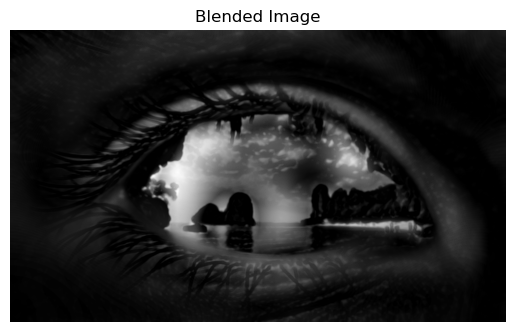

In [24]:
# Load the images and mask in grayscale
img1 = cv2.imread('1.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('2.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('mask.jpg', cv2.IMREAD_GRAYSCALE)

# Normalize the mask (in case it's not between 0 and 1)
mask = mask / 255.0

# Initialize parameters
levels = 5
sigma = 5
# Blend the images using the Laplacian pyramid method
blended_image = blend_images(img1, img2, mask, levels, sigma)

# Display the blended image
plt.imshow(blended_image, cmap="gray")
plt.title("Blended Image")
plt.axis("off")
plt.show()